In [1]:
%config InlineBackend.figure_format = "svg"

from meta import get_class_weights, Meta, to_numpy
from fitting import get_model, get_model_name
from sklearn.metrics import roc_auc_score
from dataprocessing import generate_tasks
from torch.nn import functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import pickle
import torch
import glob
import os

For the results and metrics in this notebook, skip to the `Plot metrics` section.
Also, since only some of the plots are displayed in the notebook, more plots are available in the `plots` folder.

# Load model from its filepath

In [ ]:
def fetch_model(filepath):
    
    # Model architecture
    filename = filepath.split("/")[-1]
    name = filename[:-3]
    dropout = float(name[name.find("D")+len("D"):name.find("D")+5])
    sup_shots = int(name[name.find("K")+len("K"):name.rfind("Q")])
    que_shots = int(name[name.find("Q")+len("Q"):name.rfind("-H")])
    hidden_layers = name.split("F")[1:]
    hidden_layers = [int(hl) for hl in hidden_layers]

    # Arguments to create model
    config = get_model(hidden_layers, dropout)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Choose PyTorch device and load the model
    model = Meta(name, config, sup_shots, que_shots, device).to(device)
    model.load(filepath)
    
    return model

# Define data to be used

In [ ]:
# Datapath and background file for data-files
datapath = "processed-data/"
bkg_file = datapath + "bkg.h5"

# Signal files for each task split
# val_signals = ["hg3000_hq1200", "wohg_hq1000"]
test_signals = ["wohg_hq1400", "fcnc"]

# Add datapath and extention to files for each split
# val_signals = [datapath + p + ".h5" for p in val_signals]
test_signals = [datapath + p + ".h5" for p in test_signals]

# Get metrics on the test data

In [ ]:
def get_metrics(model, sup_task, que_task, total_steps):
    # Get total steps
    # total_steps = len(list(que_task["data"]))
    
    # Iterate the whole query dataloader
    df_data = None
    roc_steps = 0
    columns = que_task["columns"]
    metrics = {"roc": 0, "acc": 0, "loss": 0, "preds": {"bkg": [], "signal": []}}
    for _ in tqdm(range(total_steps), total=total_steps, desc="Iterating task loader", leave=False):
        
        # Get support and query samples from task
        x_sup, w_sup, y_sup = next(sup_task["data"])
        sup_weights = get_class_weights(sup_task["weights"], y_sup)
        x_que, w_que, y_que = next(que_task["data"])
        que_weights = get_class_weights(que_task["weights"], y_que)
        
        # Add data to dictionary to append in metrics df
        assert len(columns) == len(x_que[0].tolist()), f"Cols: {len(columns)} | x_que: {x_que.shape}"
        if df_data is None:
            df_data = {column: [] for column in columns}
            df_data["weight"] = []
            df_data["label"] = []
            df_data["prediction"] = []
        for i, column in zip(range(len(columns)), columns):
            df_data[column] += [x.item() for x in x_que[:, i]]
        df_data["weight"] += [w for w in w_que.tolist()]
        df_data["label"] += [y for y in y_que.tolist()]

        # Normalize weights
        w_sup = w_sup / w_sup.sum() * w_sup.shape[0]
        w_que = w_que / w_que.sum() * w_que.shape[0]
        
        # Model prediction
        y_hat = model.predict(x_sup, w_sup, y_sup, x_que, sup_weights)
        
        # Get roc (try except if only one class is present in sample)
        try:
            metrics["roc"] += roc_auc_score(to_numpy(y_que), to_numpy(y_hat.round()), sample_weight=to_numpy(w_que))
            roc_steps += 1
        except:
            pass
        
        # Get accuracy and loss
        metrics["acc"] += (torch.eq(y_hat.round(), y_que) * w_que).sum().item() / y_hat.shape[0]
        metrics["loss"] += (F.binary_cross_entropy(y_hat, y_que, reduction="none") * w_que * que_weights).mean().item()
        
        # Get prediction values for signal and background
        metrics["preds"]["bkg"] += y_hat[torch.where(y_que == 0)].tolist()
        metrics["preds"]["signal"] += y_hat[torch.where(y_que == 1)].tolist()
        
        # Add new data to dataframe
        df_data["prediction"] += [y for y in y_hat.round().tolist()]
        
    # Average the metrics
    metrics["acc"] /= total_steps
    metrics["loss"] /= total_steps
    metrics["roc"] /= roc_steps
    
    # Convert lists to numpy
    metrics["preds"]["bkg"] = np.array(metrics["preds"]["bkg"])
    metrics["preds"]["signal"] = np.array(metrics["preds"]["signal"])
    
    # Assert df got populated
    df = pd.DataFrame(df_data)
    assert len(df) != 0, "DataFrame not populated!"
    # metrics["data"]["weights"] = metrics["data"]["weights"] /
    
    return metrics, df

In [ ]:
# Defining arguments for metric retrieval
sup_shots_list = [5, 10, 25, 50, 100, 250, 500]
que_shots_list = [2 * sup_shots for sup_shots in sup_shots_list]
total_samples = 50000

# Initializations
metrics = {}
model_paths = list(glob.glob("models/*.pt"))
shots_list = zip(sup_shots_list, que_shots_list)
    
# Iterate all number of support and query shots to evaluate from
for sup_shots, que_shots in tqdm(shots_list, total=len(sup_shots_list), desc="Iterating number of shots"):

    # Generate tasks
    # val_tasks = generate_tasks(val_signals, bkg_file, sup_shots, que_shots)
    test_tasks = generate_tasks(test_signals, bkg_file, sup_shots, que_shots)

    # Add entry to metrics
    shot_name = f"{sup_shots}-{que_shots}"
    metrics[shot_name] = {}
        
        # Iterate all models
    for model_path in tqdm(model_paths, total=len(model_paths), desc="Iterating models", leave=False):

        # Fetch model
        model = fetch_model(model_path)
        model_name = f"{model.k_sup}-{model.k_que}"

        # Add entry to metrics dict
        metrics[shot_name][model_name] = {}

        # Iterate all test signals
        for signal in tqdm(test_tasks, total=len(test_tasks), desc="Iterating tasks", leave=False):

            # Get support sample
            sup_task, que_task = test_tasks[signal]["sup"], test_tasks[signal]["que"]
            x_sup, w_sup, y_sup = next(sup_task["data"])
            sup_weights = get_class_weights(sup_task["weights"], y_sup)

            # Get metrics for this models, shot and task
            total_steps = total_samples // sup_shots
            metrics[shot_name][model_name][signal], df = get_metrics(model, sup_task, que_task, total_steps)
            df.to_csv(f"pred_dataframes/{shot_name}_{model_name}_{signal}.csv")
            del df

## Save metrics

Metric calculation takes a lot of time. Saving them prevents recalculating.

In [2]:
def save_metrics(data, path):
    with open(path, "wb") as f:
        pickle.dump(data, f)
        
def load_metrics(path):
    with open(path, "rb") as f:
        return pickle.load(f)

In [ ]:
save_metrics(metrics, "metric_results.pickle")

## Plot metrics

In [3]:
def plot_mm(data, metric="roc", signal="fcnc", save=False):
    
    # Get list of shots and models
    key = lambda string: int(string.split("-")[0])
    shots = sorted([key for key in data], key=key)
    models = sorted([key for key in data[shots[0]]], key=key)
    
    # Check if arguments are correct
    signals = [key for key in data[shots[0]][models[0]]]
    metrics = [key for key in data[shots[0]][models[0]][signals[0]]]
    if metric not in metrics:
        print(f"Choose a valid metric. Options are: {metrics}")
        return
    elif signal not in signals:
        print(f"Choose a valid signal. Options are: {signals}")
        return
    
    # Matrix of metrics
    matrix = [[data[shot][model][signal][metric] for model in models] for shot in shots]
    matrix = np.array(matrix)
    
    # Create figure and image
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title(f"{metric} evaluation on {signal} signal")
    ax.imshow(matrix, cmap="Reds")
    ax.set_xlabel("Model Sup-Query training shots")
    ax.set_ylabel("Sup-Query evaluation shots")

    # Create ticks
    ax.set_xticks(np.arange(len(models)))
    ax.set_yticks(np.arange(len(shots)))
    ax.set_xticklabels(models)
    ax.set_yticklabels(shots)

    # Loop over data dimensions and create text annotations.
    for i in range(len(shots)):
        for j in range(len(models)):
            text = ax.text(j, i, f"{matrix[i, j]:.4f}", ha="center", va="center", color="black")

    # Plot
    fig.tight_layout()
    if save:
        plt.savefig(f"plots/mm_{metric}_{signal}.png", dpi=300)
    plt.show()

In [4]:
# Load metrics
metrics = load_metrics("metric_results.pickle")

During training, tasks are defined by their number of **Support** and **Query** shots. The support shots are the number of samples the model can adapt to a new task from, the Query shots are the number of samples that we evaluate the generalization of the model to that task after it has learn from the Support samples.

Multiple models were trained for different numbers of Support and Query shots, but in this notebook only the best model for each setting is evaluated. Note, however, that a Model that was trained on 5 Support shots and 10 Query shots, for example, can be evaluated on a different setting, say 10 Support and 20 Query shots. 

Therefore, the metrics for all our best models can be represented in a matrix, which is done bellow. In this matrix, the `x` axis represents the setting models were trained on and the `y` axis the setting they were evaluated on.

**Expected Results**: 
- It was expected, prior to obtaining the results, that the more samples (or shots) a model had at their disposal to learn from, the better it should perform. Therefore, on the `y` axis of this matrix, the higher the number of shots, the better the metrics should be. 
- As for the `x` axis, that was not exactly what was expected. In the literature of Few-Shot Meta-Learning, models trained on fewer shots often perform better when evaluated on a higher number of shots than their training setting. Too few samples to train from, however, and those samples are hardly representative of the dataset. If training on too little samples is bad but models with fewer samples usually generalize better, the `x` axis should have a *sweet spot* for the training setting, with other settings either to its right or left performing worse.

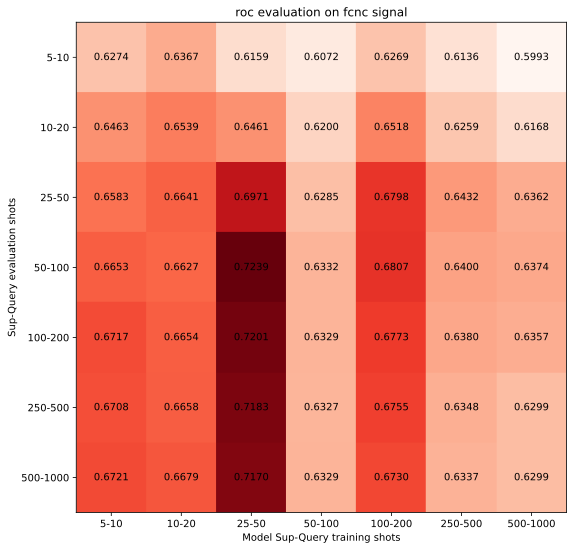

In [10]:
# Plot from the metrics dictionary
plot_mm(metrics, metric="roc", signal="fcnc", save=True)

**Actual Results**:
- `wohg_hq1400` follows the expected results.
- There is indeed a tendency on the `y` axis to have better model performance with more samples, but this is not seen everywhere in the fcnc signal.
- The `x` axis seems to have two *sweet spots* in `fcnc`, which was unexpected.

**Possible explanations for the differences**:
- For each training setting only the best model was selected. This best model comes from a pool of 30 models trained for hyperparameter optimization, which is a considerably small pool of models. In some settings, the *best* model could not be as good as the *best* model for other settings, introducing a bias in these metrics towards that setting. Increasing the size of this pool would even out these differences.
- In this study, all of the settings have a relatively small number of shots and from the results it can be said that no model did a particularly good job at generalizing, especially for the `fcnc` task. Increasing the number of shots in both the training settings could explain the difference in the expected vs actual results for the `x` axis. Say that we used for support 10, 100, 1000, 10000 shots, the difference in performance should be a lot more noticeable than above and better aligned with the expected results.

## Signal vs Background threshold distributions

In [11]:
def plot_threshold_distributions(data, signal="fcnc", bins=50, scale="linear", save=False):
    # Get list of shots and models
    key = lambda string: int(string.split("-")[0])
    shots = sorted([key for key in data], key=key)
    models = sorted([key for key in data[shots[0]]], key=key)
    
    # Check if arguments are correct
    signals = [key for key in data[shots[0]][models[0]]]
    if signal not in signals:
        print(f"Choose a valid signal. Options are: {signals}")
        return

    # Number of rows and columns
    rows = len(shots)
    columns = len(models)

    # Create axis
    fig, axs = plt.subplots(rows, columns, figsize=(35, 25))

    # Iterate list of shots
    for i, shot in enumerate(shots):
        for j, model in enumerate(models):
            axs[i, j].set_title(f"S: {shot} | M: {model} | {signal}")
            axs[i, j].hist(data[shot][model][signal]["preds"]["bkg"], bins=bins, range=(0,1), 
                           histtype="step", density=True, label="bkg")
            axs[i, j].hist(data[shot][model][signal]["preds"]["signal"], bins=bins, range=(0,1), 
                           histtype="step", density=True, label="signal")
            axs[i, j].set_yscale(scale)
            axs[i, j].legend()
    if save:
        plt.savefig(f"plots/thr_dist_{signal}.png", dpi=300)
    plt.show()

In this section we study how each model mixed signal with background. This is displayed with a "matrix of distributions", similar how we used the matrix above (training setting `M` on the x axis and evaluation setting `S` on the y axis).

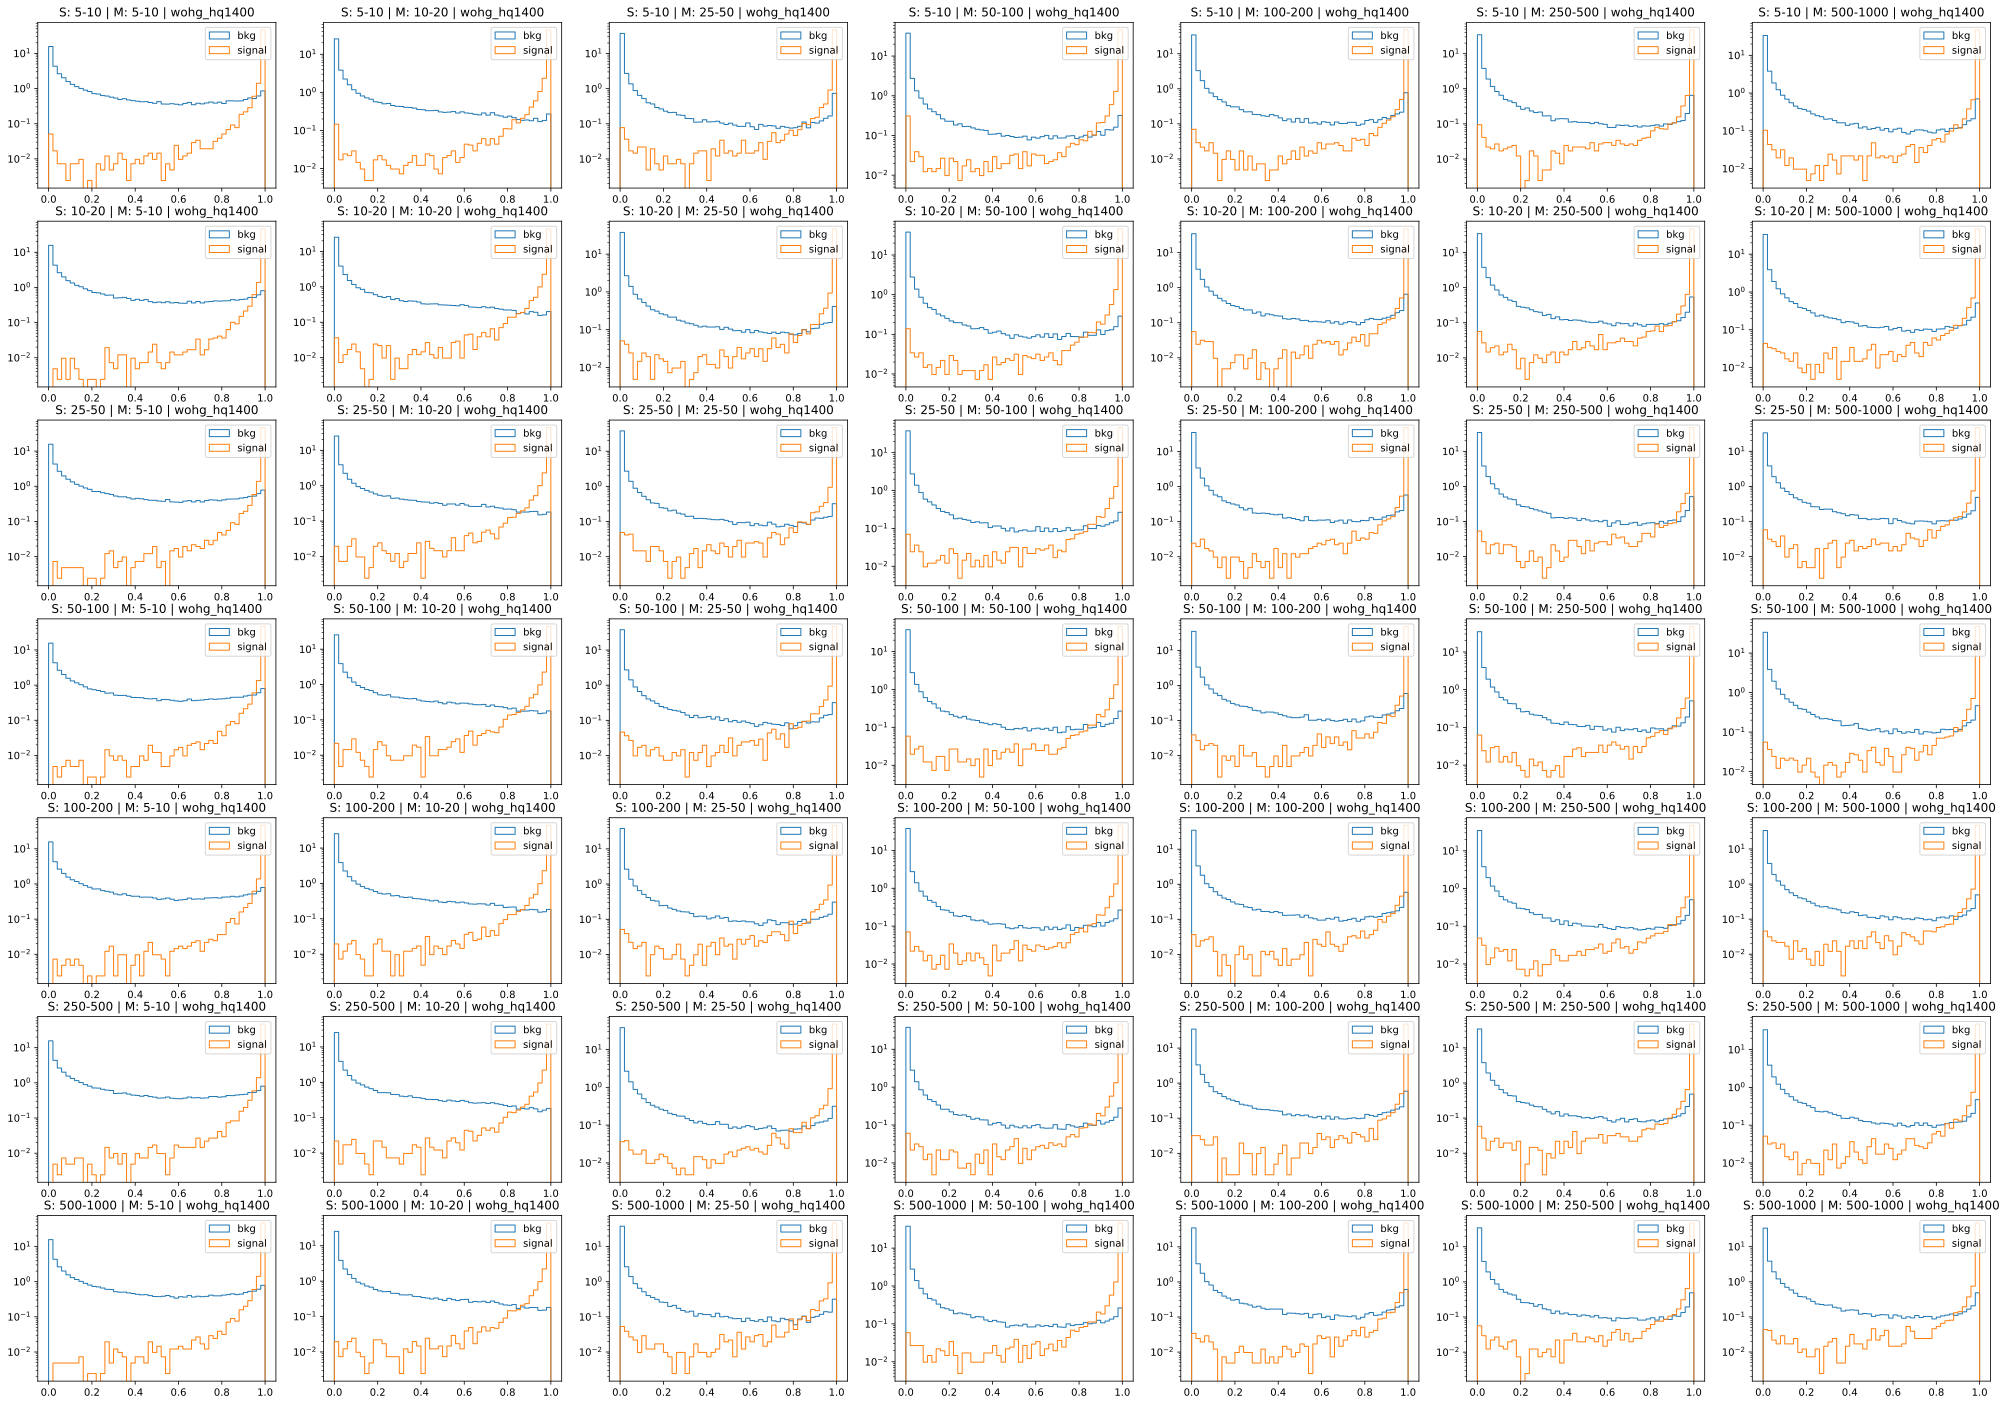

In [14]:
plot_threshold_distributions(metrics, scale="log", signal="wohg_hq1400", save=True)

From these distributions we can see that for the `fcnc` task, all models mixed a lot of the signal with background, which can be seen by the spikes around 1 for the background distributions and the spikes around 0 for the signal distribution. This is further evidence of the lack of generalization of these models.
For the `wohg_1400`, which is a lot more similar to the tasks the models were trained on, the spikes are not that noticeable and the models also perform better as was already seen in the metrics matrix above.

## Plot feature distributions

In [ ]:
# Quick file renaming fix
files = glob.glob("pred_dataframes/*.csv")
new_files = [s.replace("wohg_hq1400", "wohg-hq1400") for s in files]

for f, nf in zip(files, new_files):
    os.replace(f, nf)

In [30]:
def plot_feature_distributions(shot="250-500", model="25-50", signal="fcnc", label="signal", num_cols=5, bins=50, save=False):
    # Get list of shots and models
    df_files = [s.split("/")[-1].split(".")[0] for s in glob.glob("pred_dataframes/*.csv")]
    shots = list(set([s.split("_")[0] for s in df_files]))
    models = list(set([s.split("_")[1] for s in df_files]))
    signals = list(set([s.split("_")[2] for s in df_files]))
    labels = ["bkg", "signal"]
    
    # Check arguments
    if shot not in shots:
        print(f"Choose a valid shot setting. Options are: {shots}")
        return
    if model not in models:
        print(f"Choose a valid model. Options are: {models}")
        return
    if signal not in signals:
        print(f"Choose a valid signal. Options are: {signals}")
        return
    if label not in labels:
        print(f"Choose a valid label. Options are: {labels}")
        return
    
    # Turn label into class
    y = 0 if (label == "bkg") else 1
    
    # Get selected dataframe
    df = pd.read_csv(f"pred_dataframes/{shot}_{model}_{signal}.csv")
    
    # Create figure and axis
    unused_features = ["weight", "label", "prediction", "Unnamed: 0"]
    num_rows = int(np.ceil((len(list(df)) - len(unused_features)) / num_cols))
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(40, 60))
    
    # Iterate and plot the data
    features = [f for f in list(df) if f not in unused_features]
    for i, column in tqdm(enumerate(features), total=len(features), desc="Plotting"):
            # Define histogram range
            hist_min = min(df[df["label"] == y][column].min(), df[df["prediction"] == y][column].min())
            hist_max = max(df[df["label"] == y][column].max(), df[df["prediction"] == y][column].max())
            hist_range = (hist_min, hist_max)

            # Plot data
            row, col = int(i/num_cols), i%num_cols
            axs[row, col].set_title(column)
            axs[row, col].hist(df[df["label"] == y][column], bins=bins, label=f"true {signal} {label}", range=hist_range,
                               weights=df[df["label"] == y]["weight"], histtype='step')
            axs[row, col].hist(df[df["prediction"] == y][column], bins=bins, label=f"pred {signal} {label}", range=hist_range,
                               weights=df[df["prediction"] == y]["weight"], histtype='step')
            axs[row, col].set_yscale("log")
            axs[row, col].legend()
    if save:
        plt.savefig(f"plots/{shot}_{model}_{signal}_{label}.png", dpi=300)
    plt.show()

Finally, all feature distributions were also plotted to compare the true distributions with the ones predicted by the models.

Plotting:   0%|          | 0/69 [00:00<?, ?it/s]

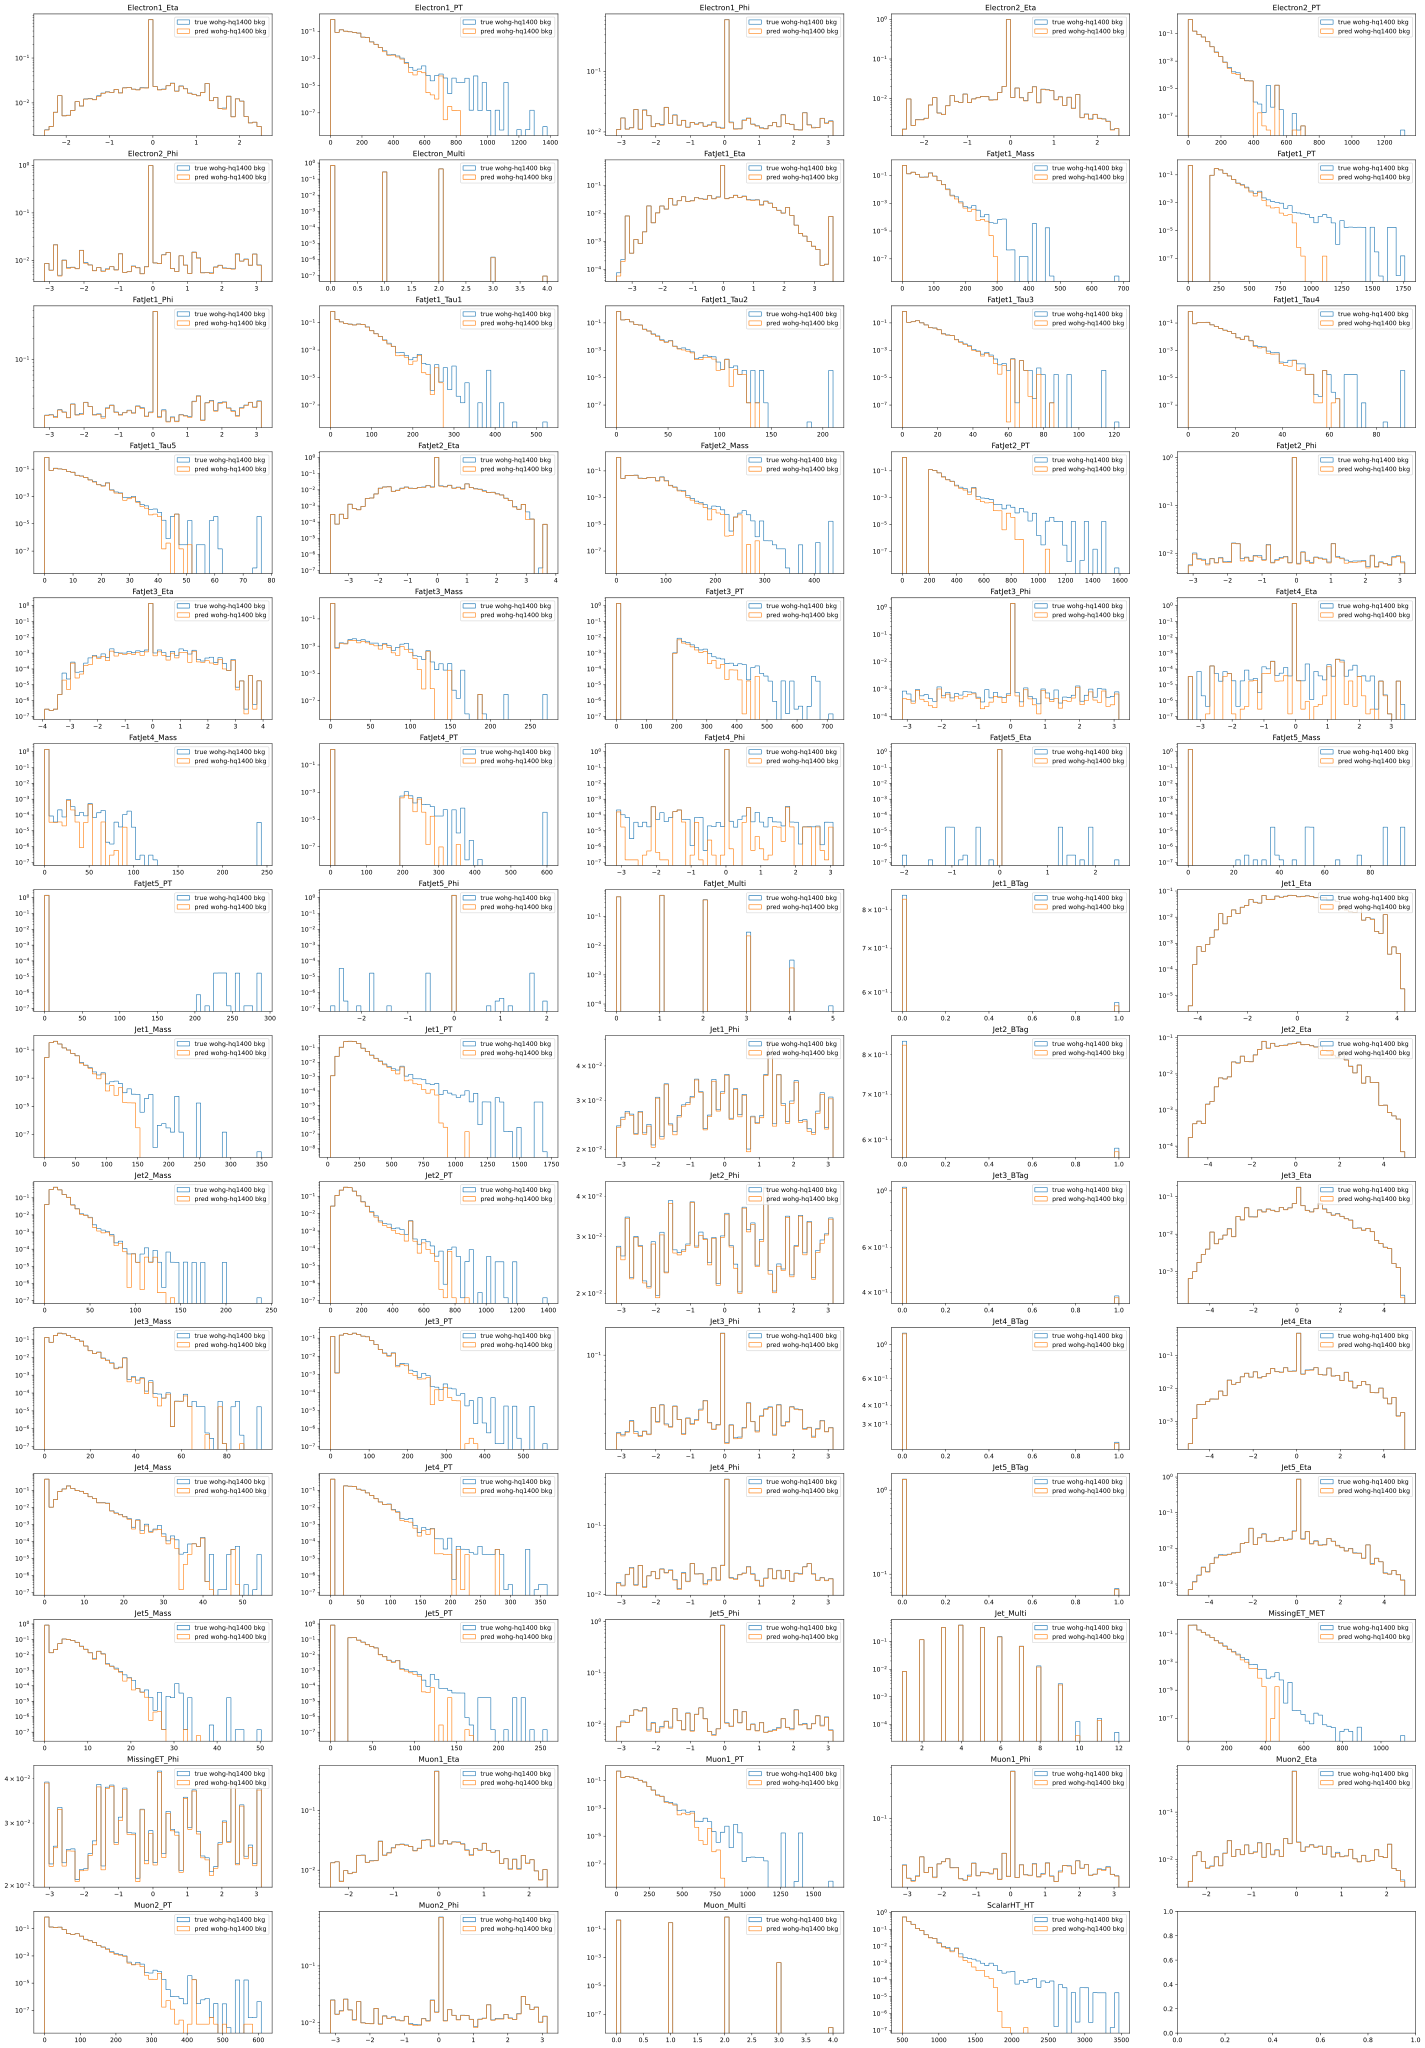

In [32]:
# Shot: Evaluation setting
# Model: Training setting
# Signal: Select the signal task
# Label: Plot either the background or signal distributions
plot_feature_distributions(shot="500-1000", model="500-1000", signal="wohg-hq1400", label="bkg", save=True)

This proves even further that the models did not generalize for the `fcnc` task. Most of the feature predicted signal distributions are very different from the actual distributions. Once again, for the `wohg_hq1400` task these differences are less noticeable.